In [13]:
# import yfinance as yf
# 下载苹果公司（AAPL）2023年至今的日线数据
# df = yf.download("MSFT", period="max")
# df.to_csv("MSFT.csv")  # 保存为CSV

In [ ]:
import pandas as pd
df = pd.read_csv('MSFT.csv')
df.head()

: 

In [15]:
df=df[['Date','Close']]
df

,Date,Close
0,1986/3/13,0.059707
1,1986/3/14,0.061839
2,1986/3/17,0.062906
3,1986/3/18,0.061306
4,1986/3/19,0.060240
...,...,...
9846,2025/4/10,381.350006
9847,2025/4/11,388.450012
9848,2025/4/14,387.809998
9849,2025/4/15,385.730011


In [16]:
import datetime
def str_to_datetime(s):#自定义一个函数，接收字符串
    split=s.split('/')
    year,month,day=int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year,month=month,day=day)#datetime.datetime 是 Python 标准库 datetime 模块中的一个类，用于处理日期和时间
datetime_object=str_to_datetime('2025/4/16')
datetime_object


datetime.datetime(2025, 4, 16, 0, 0)

In [17]:
df['Date']=df['Date'].apply(str_to_datetime)
df.index=df.pop('Date')# 将 dataFrame 的 'Date' 列从数据中弹出，并将其设置为索引
df

,Close
Date,
1986-03-13,0.059707
1986-03-14,0.061839
1986-03-17,0.062906
1986-03-18,0.061306
1986-03-19,0.060240
...,...
2025-04-10,381.350006
2025-04-11,388.450012
2025-04-14,387.809998


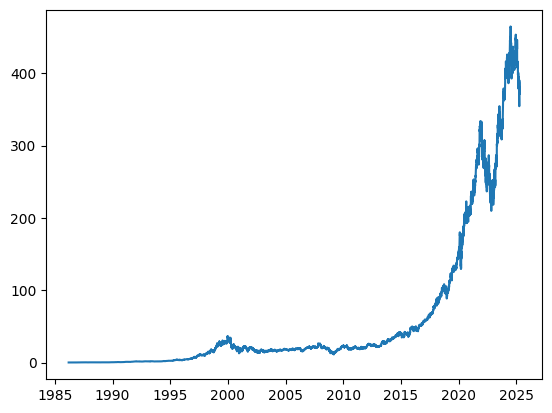

In [18]:
import matplotlib.pyplot as plt
plt.plot(df.index,df['Close'])#plot绘制

In [19]:
import numpy as np
#滑动窗口法(sliding window method)：喂它大量历史题目X+标准答案Y，让它从中学会规律
#本质是将时间序列转换为监督学习格式,构建有监督学习的数据集
#模型学的是一个映射：f：R^n->R
#目标是生成样本对（xt,yt）,and xt=[xt-n,xt-n+1,...,xt-1],yt=yt
def df_to_windowed_df(dataframe,first_date_str,last_date_str,n=3):
    #datafram包含有日期索引、Close列的股票数据.
    #first_date_str:起始时间，预测从这个日期开始
    #last_date_str：终止时间，预测到这个日期
    #n：窗口大小，表示用前 n 天预测下一天
    first_date=str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    #初始化：设置目标日期从第一个日期开始、准备空列表来储存日期，X和Y
    target_date = first_date
    dates=[]
    X,Y=[],[]

    last_time = False

    #主循环
    while True:
        #获取从开始到目标日期的数据子集，并取最后n+1个数据点
        df_subset = dataframe.loc[:target_date].tail(n+1)
        #检查是否有足够的数据点（n+1个）
        if len(df_subset) != n+1:
          print(f'Error: Window of size {n} is too large for date {target_date}')
          return
        
        #将这n+1天的数据点转为numpy数组，拆成X和Y
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]
        
        #存储当前目标日期和对应的X、Y值
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        #在当前目标日期(target_date)到之后7天的范围内查找数据,确保了即使有周末或节假日，也能找到下一个有效交易日
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        #获取前两个可能的结果(当前日期和下一个日期),取其中的最后一个获取该行的日期索引
       
        next_date_str = next_datetime_str.split('T')[0]
        #分割字符串，去掉时间部分(如果有)，只保留日期部分
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        #如果到达结束日期，设置标志位在下一次循环时退出
        if last_time:#检查last_time标志是否为True,如果为真，立即终止while True循环
            break
        target_date = next_date#将目标日期更新为刚计算出的下一个有效日期,使处理窗口向前移动
        if target_date == last_date:#检查当前目标日期是否已达到用户指定的结束日期,是个边界条件检测
           last_time = True#如果检测到已到达最后日期，设置标志位
    
    #创建一个空的 DataFrame，之后我们会一列列往里填数据。
    ret_df = pd.DataFrame({})
    #把我们在滑动窗口中用作目标的日期依次放入 Target Date 这一列
    ret_df['Target Date'] = dates
  
    #特征数据 X 从列表转换为 NumPy 数组，更便于按列提取
    X = np.array(X)
    for i in range(0, n):
        #取所有行的第i列，不是从0到i列，把X当做矩阵
        X[:, i]
        #把特征列 X[:, i] 一列一列地放进 ret_df
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    #最后一列是我们要预测的目标值
    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2021/03/25'
windowed_df = df_to_windowed_df(df, 
                                '2021/03/25', 
                                '2022/03/23', 
                                n=3)
#由滑动窗口创造出的dataframe：
windowed_df

    

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,228.180054,229.717438,227.667587,224.650864
1,2021-03-26,229.717438,227.667587,224.650864,228.653854
2,2021-03-29,227.667587,224.650864,228.653854,227.454865
3,2021-03-30,224.650864,228.653854,227.454865,224.177094
4,2021-03-31,228.653854,227.454865,224.177094,227.967316
...,...,...,...,...,...
247,2022-03-17,269.468567,279.908508,286.965973,287.774994
248,2022-03-18,279.908508,286.965973,287.774994,292.853546
249,2022-03-21,286.965973,287.774994,292.853546,291.615631
250,2022-03-22,287.774994,292.853546,291.615631,296.392029


In [20]:
#有了由滑动窗口创造出的dataframe：windowed_dataframe后
# 要把pandas表格格式的数据（dataframe）转换成可以喂给机器学习模型的三元组
def windowed_df_to_date_X_y(windowed_dataframe):
    #把整个 windowed_df 转换成 NumPy 数组，方便用索引切片来操作
    df_as_np = windowed_dataframe.to_numpy()
    #取出第一列（"Target Date"）作为日期信息
    dates = df_as_np[:, 0]
    #取出中间几列，也就是特征部分，注意 [:, 1:-1] 是去掉第一列（日期）和最后一列（真正的 target）
    middle_matrix = df_as_np[:, 1:-1]
    #把二维的变成3维的:.shape=[样本数（dataframe里多少行）, 时间步（每个样本用了多少连续时间点（3天））, 特征数（收盘价）]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    
    #为什么要 reshape 成 3 维——因为你要喂给的是LSTM / GRU / 1D CNN 这种时间序列模型

    #取出最后一列
    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)#转换为 32 位浮点数类型（神经网络模型训练常见的格式）

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

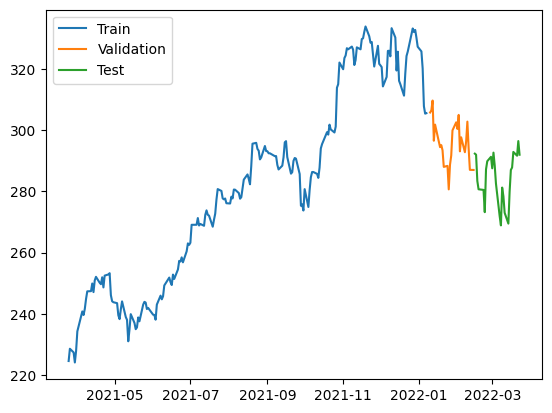

In [21]:
#数据划分:训练（大量历史题+答案，让他“学”）、验证（调节模型参数，考试之前的小测试，看他学得咋样，决定要不要换老师（模型结构））、测验（最后考试的真题，不能提前看，用来判断他到底有没有学会）
#还没有真正用模型来学习和预测
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
#TensorFlow 是一个开源深度学习框架，它能用简单的代码构建神经网络，训练模型，进行数据预测、分类、回归等任务
from tensorflow.keras.models import Sequential#最常见的一种模型结构，叫“顺序模型”。
#它适合模型是按“从左到右一层一层往下堆”的结构，比如：输入层 → LSTM → Dense → 输出层

from tensorflow.keras.optimizers import Adam#优化器，用于调整模型的参数，让误差尽量变小
#Adam 是一种非常流行的优化算法，一种常用的梯度下降优化器

from tensorflow.keras import layers#这个模块包含了各种类型的“层”（layer）
#比如：Dense：全连接层、LSTM：长短期记忆网络层（适合时间序列）、Dropout：防止过拟合的层、Conv2D：卷积层（常用于图像）

#Sequential用于创建顺序模型，layers：用于定义模型的每一层，包括输入层、LSTM 层、全连接层和输出层。
model = Sequential([layers.Input((3, 1)),#输入是一个 3x1 的矩阵
                    layers.LSTM(64),#该 LSTM 层包含64个LSTM单元（包含了细胞状态和多个门），即该层可以学习并存储 64 个不同的特征表示（生成 64 个不同的隐藏状态）
                    layers.Dense(32, activation='relu'),#定义了包含 32 个神经元的全连接层
                    layers.Dense(32, activation='relu'),#定义了另一个全连接层，意味着该层会接收来自前一层的 32 个特征输入，再次通过 ReLU 激活函数处理并输出 32 个特征。
                    layers.Dense(1)])#输出 1 个值的全连接层，没有指定激活函数，意味着它使用的是线性激活，希望输出是一个连续的数值

#用于优化模型参数
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])#metrics是一个列表，用于存储模型评估时需要计算的指标。

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)#将训练数据喂给模型，让模型通过前向传播和反向传播不断调整权重，最终优化损失函数。


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 80312.6875 - mean_absolute_error: 281.5803 - val_loss: 87106.5234 - val_mean_absolute_error: 295.0532
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 80219.8516 - mean_absolute_error: 281.4702 - val_loss: 86816.5234 - val_mean_absolute_error: 294.5613
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 78537.1953 - mean_absolute_error: 278.4412 - val_loss: 86435.9531 - val_mean_absolute_error: 293.9146
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 78927.2891 - mean_absolute_error: 279.2766 - val_loss: 85885.8281 - val_mean_absolute_error: 292.9773
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 78384.3203 - mean_absolute_error: 278.2220 - val_loss: 85275.2109 - val_mean_absolute_error: 291.9333
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 75622.6641 - mean_absolute_error: 273.1721 - val_loss: 84290.1484 - val_mean_absolute_error: 290.2412
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


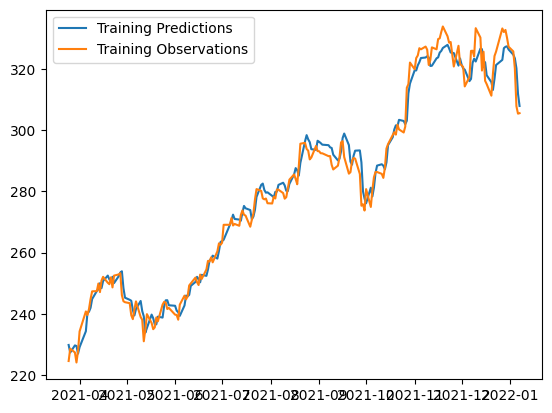

In [23]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


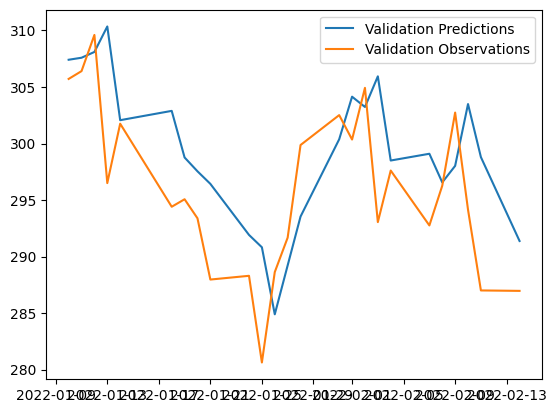

In [24]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])